### Numerical Model for Ocean Flow
Sierra Stevenson under mentorship of Dr. Marcelo Chamecki

We are solving the system of equations

$$
\begin{cases}

\frac{\partial{\bar{u}}}{\partial{t}} &= f(\bar{v} - v_g) + \frac{\partial{k}}{\partial{z}}  \frac{\partial{\bar{u}}}{\partial{z}} + k \frac{\partial{^2\bar{u}}}{\partial{z^2}} 
\\
\frac{\partial{\bar{v}}}{\partial{t}} &= f(\bar{u} - u_g) + \frac{\partial{k}}{\partial{z}}  \frac{\partial{\bar{v}}}{\partial{z}} + k \frac{\partial{^2\bar{v}}}{\partial{z^2}}

\end{cases}
$$

with boundary conditions

*surface ($z=0$):*  $k \frac{\partial{\bar{u}}}{\partial{z}} = \frac{T_x}{\rho}$,  $k \frac{\partial{\bar{v}}}{\partial{z}} = \frac{T_y}{\rho}$

*bottom ($z=-\infty$):* $\bar{u} = u_g, \bar{v} = v_g$


Knowing $u_g, v_g, k(z),$ and $f$, we want to find $\bar{u}{z}$ and $\bar{v}{z}$.<br>Testing for for $k = const.$ now.
<p>

# Code

Import libraries

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from mpl_toolkits import mplot3d
from matplotlib import animation
from IPython.display import HTML

# Font style for plotting
plt.rcParams["font.family"] = "Georgia"
plt.rcParams["font.size"] = 10

Grid

In [78]:
# Time
T = 100000                          # total seconds
dt = 15                             # time step
Nt = int(T/dt)                      # number of time steps

# Space
Z = -100                            # total meters deep
Nz = abs(Z)                         # number of grid nodes
dz = -1                             # step in z
z = np.arange(0, Z+dz, dz)          # z array from [0, -100]
z_K = z + 1/2                       # z array for K, staggered as i + 1/2

print(f"z:    {z[0]},   {z[1]},    ...,  {z[-1]}\t?")
print(f"z_K:  {z_K[0]}, {z_K[1]},  ...,  {z_K[-1]}\t?")

z:    0,   -1,    ...,  -100	?
z_K:  0.5, -0.5,  ...,  -99.5	?


Constants

In [110]:
f = 7 * 10 ** (-5)                  # coriolis parameter
tau_x_over_rho = 1 * 10 ** (-4)     # wind stress (tau_x / rho)
tau_y_over_rho = 0                  # wind stress (tau_y / rho)

ug = 0                              # geostrophic velocity
vg = 0                              # geostrophic velocity

K = np.ones(Nz) * 10 ** -2          # eddy diffusivity
dKdz = [(K[i] - K[i+1])/dz for i in z]   # dK/dz (0 for const. K)

Textbook spiral

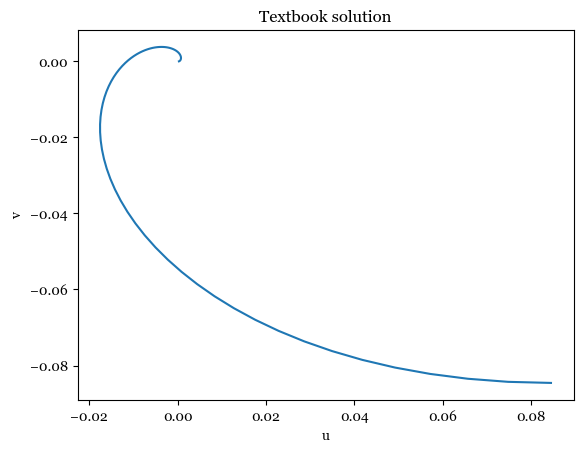

In [81]:
# Ekman spiral as known
d = np.sqrt(2 * np.mean(K) / f)
u_book = ug + (np.sqrt(2) / (f * d) * np.exp(z[::dz]/d)) * (tau_x_over_rho * np.cos(z[::dz] / d - np.pi / 4 ) - tau_y_over_rho * np.sin(z[::dz]/d - np.pi / 4))
v_book = vg + (np.sqrt(2) / (f * d) * np.exp(z[::dz]/d)) * (tau_x_over_rho * np.sin(z[::dz] / d - np.pi / 4 ) + tau_y_over_rho * np.cos(z[::dz]/d - np.pi / 4))

plt.plot(u_book, v_book), plt.title("Textbook solution"), plt.xlabel("u"), plt.ylabel("v")
plt.show()

Main loop

In [111]:
u, v = np.zeros(Nz), np.zeros(Nz)
u_saved, v_saved = np.zeros((Nz, Nt)), np.zeros((Nz, Nt))

for n in np.arange(0, T, dt):  # Loop thru time

    # Initialize arrays for next time step
    u_1, v_1 = np.zeros(Nz), np.zeros(Nz),
    u_2, v_2 = np.zeros(Nz), np.zeros(Nz),
    u_fut, v_fut = np.zeros(Nz), np.zeros(Nz),

    # BC
    u[0] = u[2] - (2 * dz * tau_x_over_rho) / K[1]
    v[0] = v[2] - (2 * dz * tau_y_over_rho) / K[1]

    for i in range(1, Nz-1): # Loop thru space
        u_1[i] = u[i] + (dt/3) * (  (f * (v[i] - vg) + (K[i] / dz ** 2) * (u[i+1] - 2 * u[i] + u[i-1])) + dKdz[i] * (u[i+1] - u[i-1])/(2*dz) )
        v_1[i] = v[i] + (dt/3) * ( (-f * (u[i] - ug) + (K[i] / dz ** 2) * (v[i+1] - 2 * v[i] + v[i-1])) + (dKdz[i]) * (v[i+1] - v[i-1])/(2*dz) )
        
    # BC
    u_1[0] = u_1[2] - (2 * dz * tau_x_over_rho) / K[1]
    v_1[0] = v_1[2] - (2 * dz * tau_y_over_rho) / K[1]
    u_1[-1] = ug
    v_1[-1] = vg

    for i in range(1, Nz-1): # Loop thru space
        u_2[i] = u[i] + (dt/2) * (  (f * (v_1[i] - vg) + (K[i] / dz ** 2) * (u_1[i+1] - 2 * u_1[i] + u_1[i-1])) + (dKdz[i]) * (u_1[i+1] - u_1[i-1])/(2*dz) )
        v_2[i] = v[i] + (dt/2) * ( (-f * (u_1[i] - ug) + (K[i] / dz ** 2) * (v_1[i+1] - 2 * v_1[i] + v_1[i-1])) + (dKdz[i]) * (v_1[i+1] - v_1[i-1])/(2*dz) )
        
    # BC
    u_2[0] = u_2[2] - (2 * dz * tau_x_over_rho) / K[1]
    v_2[0] = v_2[2] - (2 * dz * tau_y_over_rho) / K[1]
    u_2[-1] = ug
    v_2[-1] = vg

    for i in range(1, Nz-1): # Loop thru space
        u_fut[i] = u[i] + (dt) * (  (f * (v_2[i] - vg) + (K[i] / dz ** 2) * (u_2[i+1] - 2 * u_2[i] + u_2[i-1])) + (dKdz[i]) * (u_2[i+1] - u_2[i-1])/(2*dz) )
        v_fut[i] = v[i] + (dt) * ( (-f * (u_2[i] - ug) + (K[i] / dz ** 2) * (v_2[i+1] - 2 * v_2[i] + v_2[i-1])) + (dKdz[i]) * (v_2[i+1] - v_2[i-1])/(2*dz) )
    
    # BC
    u_fut[0] = u_fut[2] - (2 * dz * tau_x_over_rho) / K[1]
    v_fut[0] = v_fut[2] - (2 * dz * tau_y_over_rho) / K[1]
    u_fut[-1] = ug
    v_fut[-1] = vg

    # Update u and v to restart loop with new starting values
    u = np.copy(u_fut)
    v = np.copy(v_fut)

    # Save history
    if n%dt == 0:
        u_saved[:,int(n/dt)] = np.copy(u_fut)
        v_saved[:,int(n/dt)] = np.copy(v_fut)

KeyboardInterrupt: 

In [ ]:
# Get average value of u and v oscillations, should be period 2pi/f
u_avg = np.mean(u_saved, axis=1)
v_avg = np.mean(v_saved, axis=1)

Plots

$u$ vs. $v$ hodograph

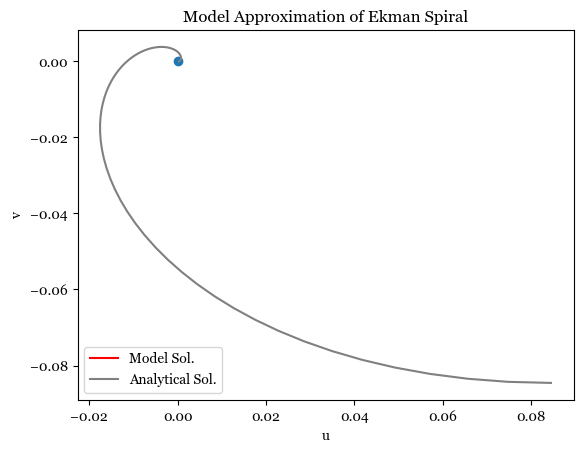

In [92]:
# Plot avg'd model solution
plt.plot(u_avg[1:], v_avg[1:], color='red', zorder=3, label="Model Sol.", ls="-")

# Analytical plot
plt.plot(u_book, v_book, color='gray', linestyle='-', label="Analytical Sol.")

plt.scatter(0,0)
plt.xlabel("u")
plt.ylabel("v")
plt.title("Model Approximation of Ekman Spiral")
plt.legend(loc="lower left")
plt.show()

$u$ and $v$ depth profiles

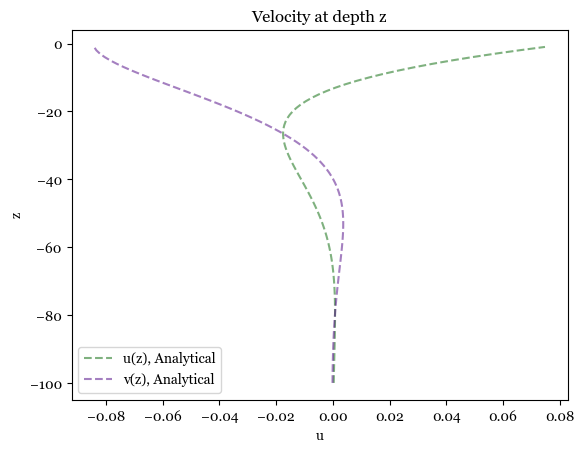

In [ ]:
# Model plot
a = 2
b = -1

# plt.plot(u_saved[a:b], z[b:a:-1], label="u(z), Model", color="green")
# plt.plot(v_saved[a:b], z[b:a:-1], label="v(z), Model", color="darkblue")

# Analytical plot
plt.plot(u_book, z, label="u(z), Analytical", color="darkgreen", alpha=0.5, linestyle="--")
plt.plot(v_book, z, label="v(z), Analytical", color="indigo", alpha=0.5, linestyle="--")

# Plot labels
plt.xlabel("u")
plt.ylabel("z")
plt.title("Velocity at depth z")
plt.legend()
plt.show()

Time evolution of ($u_1, v_1$)

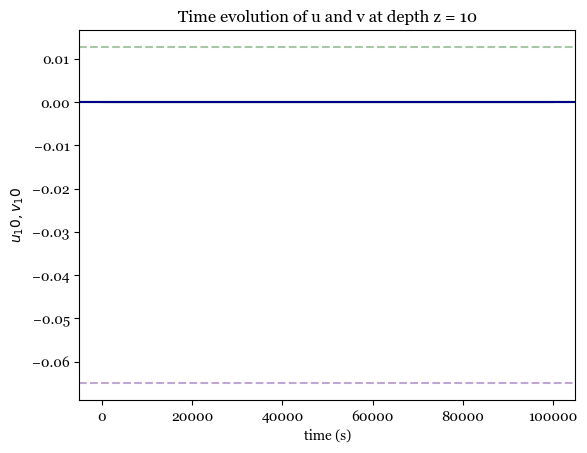

In [ ]:
def PlotTimeEvolutionAt(depth):
    # Model plot
    plt.plot(u_saved[depth+1,2:-1], label="u(z), Model", color="green", alpha=0.25)
    plt.plot(v_saved[depth+1,2:-1], label="v(z), Model", color="darkblue", alpha=0.25)

    plt.axhline(u_avg[depth+1], label="u(z), Model Avg'd", color="green")
    plt.axhline(v_avg[depth+1], label="v(z), Model Avg'd", color="darkblue")

    # Analytical plot
    plt.axhline(u_book[-depth], label="u(z), Analytical", color="darkgreen", alpha=0.35, linestyle="--")
    plt.axhline(v_book[-depth], label="v(z), Analytical", color="indigo", alpha=0.35, linestyle="--")

    # Plot labels
    plt.xlabel("time (s)")
    plt.ylabel(f"$u_{depth}, v_{depth}$")
    plt.title(f"Time evolution of u and v at depth z = {depth}")
    # plt.legend()
    plt.show()

# PlotTimeEvolutionAt(1)
PlotTimeEvolutionAt(10)
# PlotTimeEvolutionAt(30)
# PlotTimeEvolutionAt(50)
# PlotTimeEvolutionAt(80)